<h1 align = 'center'> NASA | Nearest Earth Objects (1910-2024) </h1>

## Importing Required Standard Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


## Loading the Data Set

In [3]:
data_file_path = 'C:/Users/naren/OneDrive/Documents/AA ... INTERVIEW PREP WORK/NASA_Nearest earth objects(1910-2024)/input/nearest-earth-objects(1910-2024).csv'

In [4]:
df = pd.read_csv(data_file_path)

##  Data Cleaning and analysis

In [5]:
df.head()

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False


In [6]:
df.shape

(338199, 9)

In [7]:
# Examining the orbiting body column of the data set
df['orbiting_body'].nunique()

1

#### - Since the `orbiting body` is consistent across all instances, this column does not provide additional information for learning and can therefore be omitted.

In [8]:
df.dtypes

neo_id                      int64
name                       object
absolute_magnitude        float64
estimated_diameter_min    float64
estimated_diameter_max    float64
orbiting_body              object
relative_velocity         float64
miss_distance             float64
is_hazardous                 bool
dtype: object

#### - The `neo_id` and `name` columns contain unique identifiers for each object. Since they do not contribute additional information for the learning process, they can be excluded.

### Examining Missing Values

In [9]:
df.isna().sum()

neo_id                     0
name                       0
absolute_magnitude        28
estimated_diameter_min    28
estimated_diameter_max    28
orbiting_body              0
relative_velocity          0
miss_distance              0
is_hazardous               0
dtype: int64

#### Will just delete the missing records since there are only 28 of them

In [9]:
df = df.dropna()

## Exploratory Data Analysis

### Examining the distribution of Target Class

In [10]:
df['is_hazardous'].value_counts()

is_hazardous
False    295009
True      43162
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of target variable in the data set')

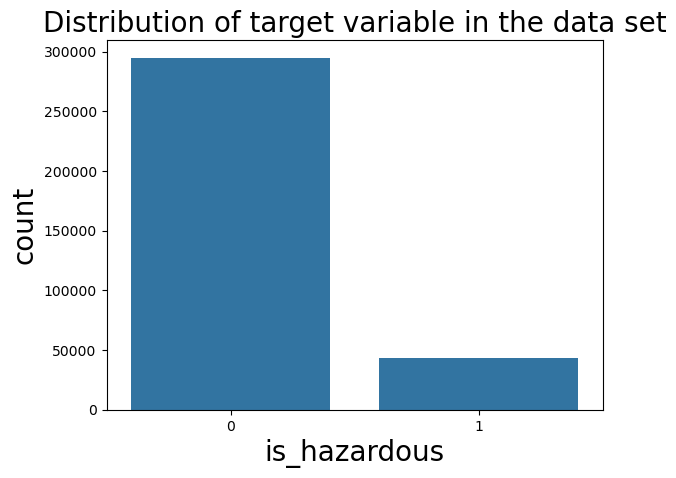

In [46]:
b = sns.countplot(x = 'is_hazardous', data = df)
b.set_xlabel(xlabel='is_hazardous', fontsize = 20)
b.set_ylabel(ylabel='count', fontsize = 20)
b.set_title('Distribution of target variable in the data set', fontsize = 20)

### The data is clearely skewed so our metric for evaluation should not be accuracy. We have to look into recall and precision.

In [13]:
df_eda = df.drop(columns = ['name', 'neo_id', 'orbiting_body'])

### Check basic statistics of the numerical columns

In [16]:
df_eda.describe()

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance
count,338171.000000,338171.000000,338171.000000,338171.000000,3.381710e+05
mean,22.932525,0.157812,0.352878,51060.017994,4.153547e+07
std,2.911216,0.313885,0.701869,26399.922830,2.077411e+07
min,9.250000,0.000511,0.001143,203.346433,6.745533e+03
25%,20.740000,0.025384,0.056760,30710.626399,2.494495e+07
50%,22.800000,0.073207,0.163697,47557.046397,4.332724e+07
75%,25.100000,0.189041,0.422708,66673.223798,5.933961e+07
max,33.580000,37.545248,83.953727,291781.106613,7.479865e+07


### Visulaizing the pairwise distribution between different features of the data set.

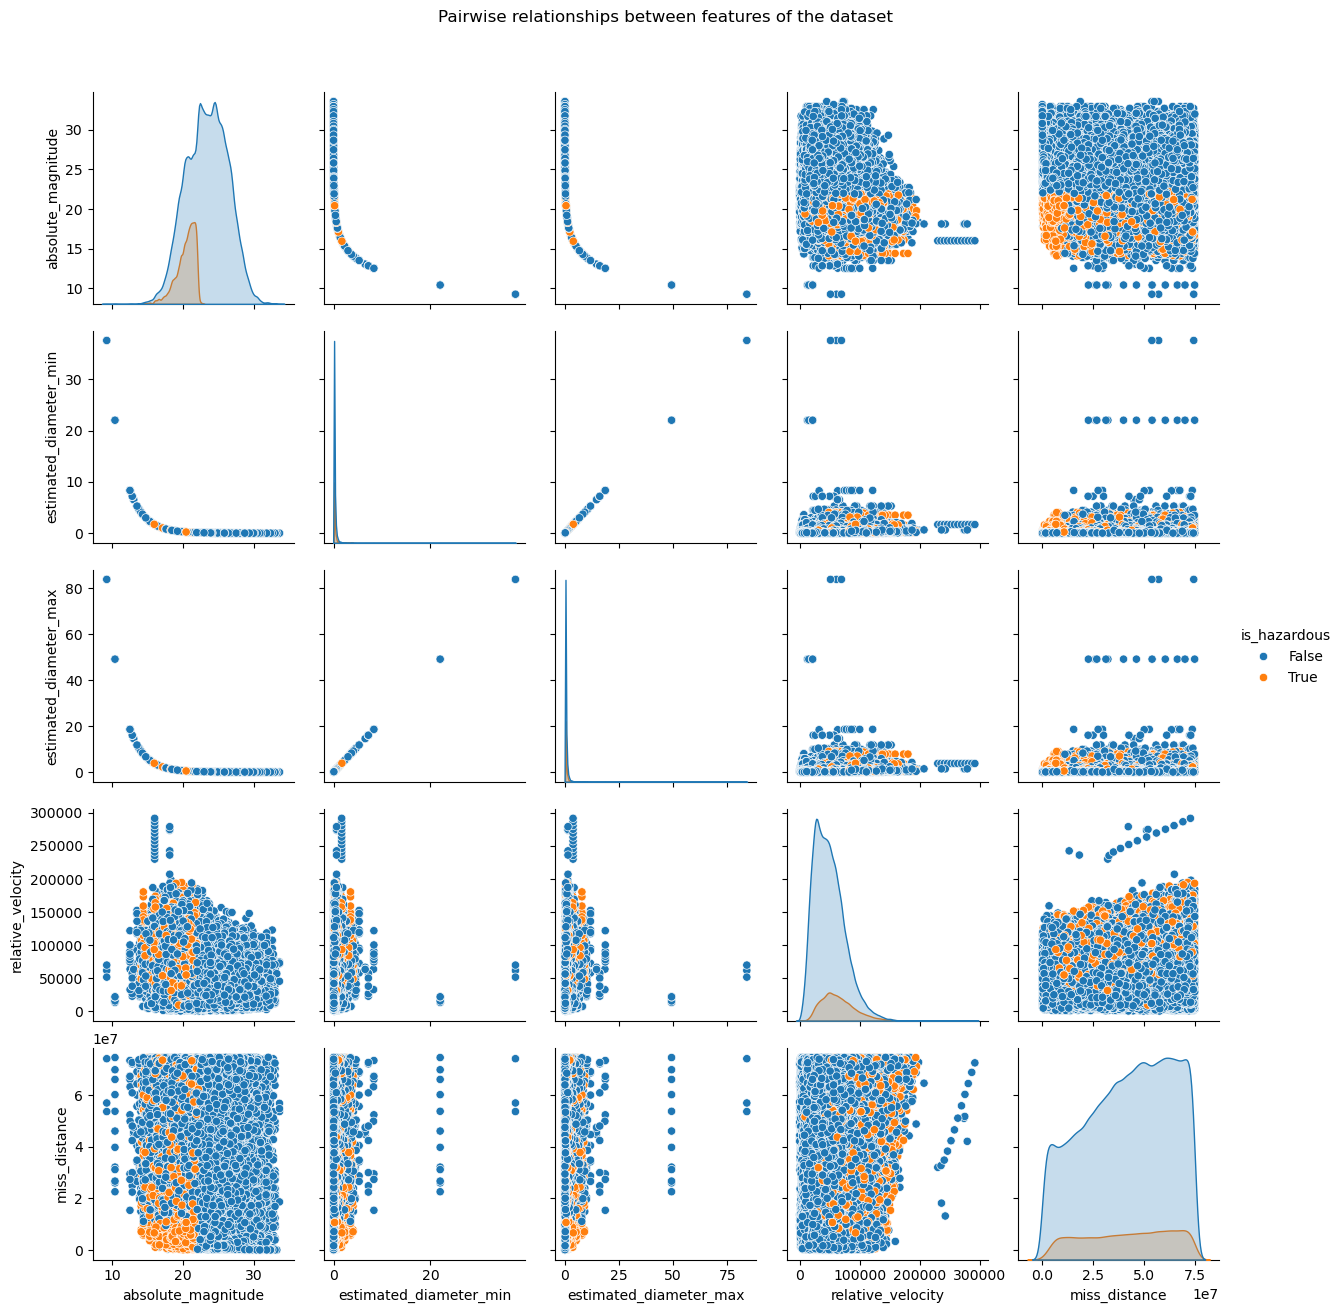

In [12]:
# Create a pairplot with the species column used for coloring
plot = sns.pairplot(df.drop(columns = ['name', 'neo_id', 'orbiting_body']), hue='is_hazardous', height=2.5)

# Add a title to the plot
plot.fig.suptitle("Pairwise relationships between features of the dataset", y=1.05)

# Show the plot
plt.show()

### Correlation heat map

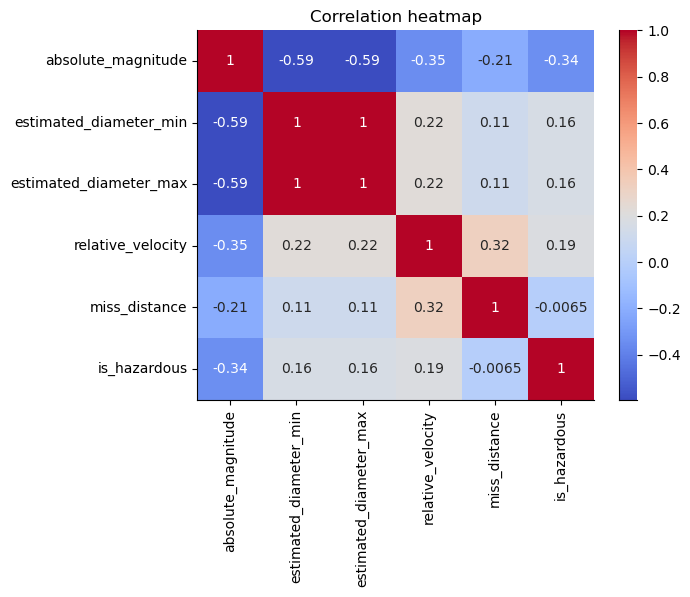

In [14]:
sns.heatmap(df_eda.corr(), cmap='coolwarm', annot=True)
plt.title('Correlation heatmap')
sns.despine()
plt.show()

### Will replace the Boolean values in `is_hazardous` column with 0's and 1's.

In [13]:
df['is_hazardous'] = df['is_hazardous'].apply(lambda x: 1 if x == True else 0)

## Data Preprocessing

### Applying **Stratified K-Fold**  to the Dataset

- Initialize a new column called `kfold` and set its value to -1 for all rows.
- After applying **StratifiedKFold**, assign the appropriate fold number to the kfold column for each instance.
- This setup allows us to perform **cross-validation**, where instances with a specific kfold value (e.g., kfold = 1) are used as the validation set, while the others serve as the training set.
- The dataset with the kfold column populated will be saved for cross-validating our models.

In [14]:
from sklearn.model_selection import StratifiedKFold

# We create a new column callded kfold and fill it with -1
df['kfold'] = -1

# The next step is to randomize the rows of the data
df = df.sample(frac = 1).reset_index(drop = True)

# Fetch targets
y = df.is_hazardous.values

# intiate kfold class from model_selection module
kf = StratifiedKFold(n_splits = 5)

# Fill the new kfold column
for f, (t_, v_) in enumerate(kf.split(X = df, y = y)):
    df.loc[v_, 'kfold'] = f
    
df.to_csv('./input/train_folds.csv', index = False)

In [15]:
data = pd.read_csv('C:/Users/naren/OneDrive/Documents/AA ... INTERVIEW PREP WORK/NASA_Nearest earth objects(1910-2024)/input/train_folds.csv')
data.drop(columns = ['neo_id', 'name', 'orbiting_body'], inplace = True)

In [16]:
data

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance,is_hazardous,kfold
0,22.460,0.085616,0.191443,40678.019145,5.526733e+07,0,0
1,20.210,0.241299,0.539560,36911.195300,2.553330e+07,0,0
2,17.640,0.788052,1.762138,46527.097830,3.340349e+07,1,0
3,23.830,0.045557,0.101869,23650.729673,1.849606e+06,0,0
4,26.262,0.014865,0.033238,34148.835715,6.934174e+06,0,0
...,...,...,...,...,...,...,...
338166,29.000,0.004213,0.009420,14856.922142,2.355054e+07,0,4
338167,26.160,0.015580,0.034837,13497.741847,6.275564e+06,0,4
338168,20.800,0.183889,0.411188,51484.716392,2.568565e+07,0,4
338169,22.200,0.096506,0.215794,72827.043919,6.652017e+07,0,4


## Model Training

### Logistic Regression model

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

test_accuracy = []
test_precision = []
test_recall = []

train_accuracy = []
train_precision = []
train_recall = []

for fold in range(5):
    x_train = data[data['kfold'] != fold].drop(columns = ['is_hazardous',  'kfold'])
    y_train = data[data['kfold'] != fold]['is_hazardous']
    x_test = data[data['kfold'] == fold].drop(columns = ['is_hazardous', 'kfold'])
    y_test = data[data['kfold'] == fold]['is_hazardous']
    
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    model = LogisticRegression()
    model.fit(x_train_scaled, y_train)
    y_pred = model.predict(x_test_scaled)
    test_accuracy.append(accuracy_score(y_pred, y_test))
    test_precision.append(precision_score(y_pred, y_test))
    test_recall.append(recall_score(y_pred, y_test))
    
    y_pred = model.predict(x_train_scaled)
    train_accuracy.append(accuracy_score(y_pred, y_train))
    train_precision.append(precision_score(y_pred, y_train))
    train_recall.append(recall_score(y_pred, y_train))
    
print("Evaluating on the training data\n")
print('accuracy :', train_accuracy)
print('precision', train_precision)
print('recall :', train_recall)

print('\nMean Accuracy :', sum(train_accuracy)/5)
print('Mean Precision :', sum(train_precision)/5)
print('Mean Recall', sum(train_recall)/5)

print('\n\n')
print("Evaluating on the testing data\n")
print('accuracy :', test_accuracy)
print('precision', test_precision)
print('recall :', test_recall)

print('\nMean Accuracy :', sum(test_accuracy)/5)
print('Mean Precision :', sum(test_precision)/5)
print('Mean Recall', sum(test_recall)/5)



Evaluating on the training data

accuracy : [0.871935712807168, 0.8717328868140033, 0.8717624576305644, 0.8717365831660734, 0.8719472752340715]
precision [0.0722001795592111, 0.07072111207645526, 0.07167680278019113, 0.07161888213147988, 0.07301109212545975]
recall : [0.48853615520282184, 0.4830860534124629, 0.48406023860747116, 0.48338545738858485, 0.48894491854150507]

Mean Accuracy : 0.8718229831303761
Mean Precision : 0.07184561373455942
Mean Recall 0.4856025646305692



Evaluating on the testing data

accuracy : [0.8710283137428846, 0.8726084513706124, 0.87217967294556, 0.8720318183162314, 0.8714551852618505]
precision [0.06915324916019923, 0.07738646895273402, 0.07263670064874884, 0.06916126042632066, 0.0726282868064404]
recall : [0.4649532710280374, 0.5060606060606061, 0.494869771112865, 0.4905505341002465, 0.4768060836501901]

Mean Accuracy : 0.8718606883274278
Mean Precision : 0.07219319319888863
Mean Recall 0.486648053190389


### Decision Tree Classifier

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

test_accuracy = []
test_precision = []
test_recall = []

train_accuracy = []
train_precision = []
train_recall = []

for fold in range(5):
    x_train = data[data['kfold'] != fold].drop(columns = ['is_hazardous', 'kfold'])
    y_train = data[data['kfold'] != fold]['is_hazardous']
    x_test = data[data['kfold'] == fold].drop(columns = ['is_hazardous', 'kfold'])
    y_test = data[data['kfold'] == fold]['is_hazardous']
    
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    model = DecisionTreeClassifier()
    model.fit(x_train_scaled, y_train)
    
    y_pred = model.predict(x_test_scaled)
    test_accuracy.append(accuracy_score(y_pred, y_test))
    test_precision.append(precision_score(y_pred, y_test))
    test_recall.append(recall_score(y_pred, y_test))
    
    y_pred = model.predict(x_train_scaled)
    train_accuracy.append(accuracy_score(y_pred, y_train))
    train_precision.append(precision_score(y_pred, y_train))
    train_recall.append(recall_score(y_pred, y_train))
    
print("Evaluating on the training data\n")
print('accuracy :', train_accuracy)
print('precision', train_precision)
print('recall :', train_recall)

print('\nMean Accuracy :', sum(train_accuracy)/5)
print('Mean Precision :', sum(train_precision)/5)
print('Mean Recall', sum(train_recall)/5)

print('\n')
print("Evaluating on the testing data\n")
print('accuracy :', test_accuracy)
print('precision', test_precision)
print('recall :', test_recall)

print('\nMean Accuracy :', sum(test_accuracy)/5)
print('Mean Precision :', sum(test_precision)/5)
print('Mean Recall', sum(test_recall)/5)


Evaluating on the training data

accuracy : [1.0, 1.0, 1.0, 1.0, 1.0]
precision [1.0, 1.0, 1.0, 1.0, 1.0]
recall : [1.0, 1.0, 1.0, 1.0, 1.0]

Mean Accuracy : 1.0
Mean Precision : 1.0
Mean Recall 1.0


Evaluating on the testing data

accuracy : [0.8894950839062615, 0.8895969482804507, 0.8906762870745483, 0.8877635508767779, 0.8873199869887927]
precision [0.5732653770415846, 0.5740268767377201, 0.5751853568118629, 0.5708989805375347, 0.5753503996293293]
recall : [0.566311935004005, 0.566609491137793, 0.5712149102623102, 0.5590470788428814, 0.5567137413136068]

Mean Accuracy : 0.8889703714253662
Mean Precision : 0.5737453981516064
Mean Recall 0.5639794313121193


### Clearly the model is overfitting. We'll do a hyperparameter tuning to deal with it.

In [49]:
from sklearn.model_selection import GridSearchCV

fold = 1
x_train = data[data['kfold'] != fold].drop(columns = ['is_hazardous', 'kfold'])
y_train = data[data['kfold'] != fold]['is_hazardous']
x_test = data[data['kfold'] == fold].drop(columns = ['is_hazardous', 'kfold'])
y_test = data[data['kfold'] == fold]['is_hazardous']


param_grid = {
    'max_depth' : [10,20,30, None],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [1,2,4]
}

# Initialize a decision tree regressor
d_tree = DecisionTreeClassifier(random_state = 42)
grid_search = GridSearchCV(estimator = d_tree,param_grid= param_grid,
                           cv = 5,
                           n_jobs = 3,
                           verbose = 2,
                           scoring = 'recall')

grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=3,
             param_grid={'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='recall', verbose=2)

### Evaluating the Tuned model

In [51]:
best_model = grid_search.best_estimator_

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

test_accuracy = []
test_precision = []
test_recall = []

train_accuracy = []
train_precision = []
train_recall = []

for fold in range(5):
    x_train = data[data['kfold'] != fold].drop(columns = ['is_hazardous', 'kfold'])
    y_train = data[data['kfold'] != fold]['is_hazardous']
    x_test = data[data['kfold'] == fold].drop(columns = ['is_hazardous', 'kfold'])
    y_test = data[data['kfold'] == fold]['is_hazardous']
    
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    model = best_model
    
    y_pred = model.predict(x_test_scaled)
    test_accuracy.append(accuracy_score(y_pred, y_test))
    test_precision.append(precision_score(y_pred, y_test))
    test_recall.append(recall_score(y_pred, y_test))
    
    y_pred = model.predict(x_train_scaled)
    train_accuracy.append(accuracy_score(y_pred, y_train))
    train_precision.append(precision_score(y_pred, y_train))
    train_recall.append(recall_score(y_pred, y_train))
    
print("Evaluating on the training data\n")
print('accuracy :', train_accuracy)
print('precision', train_precision)
print('recall :', train_recall)

print('\nMean Accuracy :', sum(train_accuracy)/5)
print('Mean Precision :', sum(train_precision)/5)
print('Mean Recall', sum(train_recall)/5)

print('\n')
print("Evaluating on the testing data\n")
print('accuracy :', test_accuracy)
print('precision', test_precision)
print('recall :', test_recall)

print('\nMean Accuracy :', sum(test_accuracy)/5)
print('Mean Precision :', sum(test_precision)/5)
print('Mean Recall', sum(test_recall)/5)


Evaluating on the training data

accuracy : [0.9196410089599906, 0.8747601991594496, 0.9012186872775259, 0.8960659724917479, 1.0]
precision [0.6950968750905037, 0.5156675354763973, 0.6153489719084854, 0.6141326382855488, 1.0]
recall : [0.6815948655326158, 0.5092666742935591, 0.6125108100317094, 0.5890555555555556, 1.0]

Mean Accuracy : 0.9183371735777428
Mean Precision : 0.6880492041521871
Mean Recall 0.678485581082688


Evaluating on the testing data

accuracy : [0.9376210541879204, 0.8840228287547683, 0.9158411449862495, 0.9093651122216636, 0.888044474672502]
precision [0.7664774701725935, 0.5522474513438369, 0.6654309545875811, 0.6629981464318814, 0.5780145951581143]
recall : [0.7502267573696145, 0.5450491653327235, 0.671970051474029, 0.6398703041144902, 0.5594797623051911]

Mean Accuracy : 0.9069789229646208
Mean Precision : 0.6450337235388014
Mean Recall 0.6333192081192097


### Random Forest Classifier

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

test_accuracy = []
test_precision = []
test_recall = []

train_accuracy = []
train_precision = []
train_recall = []

for fold in range(5):
    x_train = data[data['kfold'] != fold].drop(columns = ['is_hazardous', 'kfold'])
    y_train = data[data['kfold'] != fold]['is_hazardous']
    x_test = data[data['kfold'] == fold].drop(columns = ['is_hazardous', 'kfold'])
    y_test = data[data['kfold'] == fold]['is_hazardous']
    
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    model = RandomForestClassifier()
    model.fit(x_train_scaled, y_train)
    
    y_pred = model.predict(x_test_scaled)
    test_accuracy.append(accuracy_score(y_pred, y_test))
    test_precision.append(precision_score(y_pred, y_test))
    test_recall.append(recall_score(y_pred, y_test))
    
    y_pred = model.predict(x_train_scaled)
    train_accuracy.append(accuracy_score(y_pred, y_train))
    train_precision.append(precision_score(y_pred, y_train))
    train_recall.append(recall_score(y_pred, y_train))
    
print("Evaluating on the training data\n")
print('accuracy :', train_accuracy)
print('precision', train_precision)
print('recall :', train_recall)

print('\nMean Accuracy :', sum(train_accuracy)/5)
print('Mean Precision :', sum(train_precision)/5)
print('Mean Recall', sum(train_recall)/5)

print('\n')
print("Evaluating on the testing data\n")
print('accuracy :', test_accuracy)
print('precision', test_precision)
print('recall :', test_recall)

print('\nMean Accuracy :', sum(test_accuracy)/5)
print('Mean Precision :', sum(test_precision)/5)
print('Mean Recall', sum(test_recall)/5)


Evaluating on the training data

accuracy : [0.9999852145370671, 0.9999852145917194, 0.9999815182396493, 0.9999889109437896, 0.9999815182396493]
precision [0.9998841553476787, 0.9998841587025775, 0.9998551983782218, 0.9999131190269331, 0.9998841553476787]
recall : [1.0, 1.0, 1.0, 1.0, 0.9999710363204541]

Mean Accuracy : 0.9999844753103749
Mean Precision : 0.999884157360618
Mean Recall 0.9999942072640909


Evaluating on the testing data

accuracy : [0.9169956383529237, 0.9188869503504155, 0.9187686666469527, 0.9163586361888991, 0.9172014075760712]
precision [0.5841538283331402, 0.5868860055607044, 0.5864226135310473, 0.5791241890639481, 0.5914514073902467]
recall : [0.7135984151690958, 0.7251646149441741, 0.7245920412253077, 0.7118040723337605, 0.7112411199331383]

Mean Accuracy : 0.9176422598230524
Mean Precision : 0.5856076087758173
Mean Recall 0.7172800527210954


### This again requires tuning of the hyper parameters.


### **Tuning Phase 1**

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

fold = 1
x_train = data[data['kfold'] != fold].drop(columns=['is_hazardous', 'kfold'])
y_train = data[data['kfold'] != fold]['is_hazardous']
x_test = data[data['kfold'] == fold].drop(columns=['is_hazardous', 'kfold'])
y_test = data[data['kfold'] == fold]['is_hazardous']

# Define the RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=42)

# Define the grid of hyperparameters
param_grid = {
    'n_estimators': [100, 120, 150, 200],
    'max_depth': [5, 8, 15, 25,  None],
    'min_samples_split': [2, 3, 5, 10],  # Adjusted to start at 2
  # Pass as strings
}

# Set up the GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    n_jobs=-1,  # Use all available processors
    scoring='recall',
    cv=2,  # Typically a higher value than 2 is used
    verbose=2
)

# Fit the grid_search to the training data
grid_search.fit(x_train, y_train)

# Optionally, you can print the best parameters found
print("Best Hyperparameters:", grid_search.best_params_)


Fitting 2 folds for each of 80 candidates, totalling 160 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [21]:
import pickle
with open('tuned_rf_model.pkl', 'wb') as file:
    pickle.dump(grid_search.best_estimator_, file)

### **Tuning Phase 2**

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

fold = 1
x_train = data[data['kfold'] != fold].drop(columns=['is_hazardous', 'kfold'])
y_train = data[data['kfold'] != fold]['is_hazardous']
x_test = data[data['kfold'] == fold].drop(columns=['is_hazardous', 'kfold'])
y_test = data[data['kfold'] == fold]['is_hazardous']

# Define the RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=42)

# Define the grid of hyperparameters
param_grid = {
    'n_estimators': [150, 180, 200, 230],
    'max_depth': [30, 50, None],
    'min_samples_split': [2],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['log2', 'sqrt', None]  # Corrected key with an underscore
}

# Set up the GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    n_jobs=-1,  # Use all available processors
    scoring='recall',  # Optimize for recall
    cv=2,  
    verbose=3
)

# Fit the grid_search to the training data
grid_search.fit(x_train, y_train)

# Optionally, you can print the best parameters found
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 2 folds for each of 144 candidates, totalling 288 fits


c:\Users\naren\anaconda3\envs\nasa\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 230}


In [31]:
import pickle
with open('tuned_rf_model_ph2.pkl', 'wb') as file:
    pickle.dump(grid_search.best_estimator_, file)

### Evaluating the Tuned model

In [37]:
with open('tuned_rf_model.pkl', 'rb') as model:
    best_model = pickle.load(model)

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score

test_accuracy = []
test_precision = []
test_recall = []
test_roc = []

train_accuracy = []
train_precision = []
train_recall = []
train_roc = []

model = best_model

for fold in range(5):
    x_train = data[data['kfold'] != fold].drop(columns = ['is_hazardous', 'kfold'])
    y_train = data[data['kfold'] != fold]['is_hazardous']
    x_test = data[data['kfold'] == fold].drop(columns = ['is_hazardous', 'kfold'])
    y_test = data[data['kfold'] == fold]['is_hazardous']
    
    y_pred = model.predict(x_test)
    test_accuracy.append(accuracy_score(y_pred, y_test))
    test_precision.append(precision_score(y_pred, y_test))
    test_recall.append(recall_score(y_pred, y_test))
    test_roc.append(roc_auc_score(y_test, y_pred))
    
    y_pred = model.predict(x_train)
    train_accuracy.append(accuracy_score(y_pred, y_train))
    train_precision.append(precision_score(y_pred, y_train))
    train_recall.append(recall_score(y_pred, y_train))
    train_roc.append(roc_auc_score(y_train, y_pred))
    
print("Evaluating on the training data\n")
print('accuracy :', train_accuracy)
print('precision', train_precision)
print('recall :', train_recall)
print('AUC Score:', train_roc)

print('\nMean Accuracy :', sum(train_accuracy)/5)
print('Mean Precision :', sum(train_precision)/5)
print('Mean Recall', sum(train_recall)/5)


print('\n')
print("Evaluating on the testing data\n")
print('accuracy :', test_accuracy)
print('precision', test_precision)
print('recall :', test_recall)
print('AUC Score:', test_roc)

print('\nMean Accuracy :', sum(test_accuracy)/5)
print('Mean Precision :', sum(test_precision)/5)
print('Mean Recall', sum(test_recall)/5)


Evaluating on the training data

accuracy : [0.979444510157613, 1.0, 0.9794445861379405, 0.9794445861379405, 0.9794445861379405]
precision [0.8974195603695444, 1.0, 0.8974225311323487, 0.8974225311323487, 0.8974195603695444]
recall : [0.9388293037629521, 1.0, 0.9388311570272972, 0.9388311570272972, 0.9388293037629521]
AUC Score: [0.9444323646843845, 1.0, 0.9444338500657867, 0.9444338500657867, 0.944432382808412]

Mean Accuracy : 0.9835556537142869
Mean Precision : 0.9179368366007573
Mean Recall 0.9510641843160998


Evaluating on the testing data

accuracy : [1.0, 0.9177780406304521, 1.0, 1.0, 1.0]
precision [1.0, 0.5896663577386468, 1.0, 1.0, 1.0]
recall : [1.0, 0.7159938106625404, 1.0, 1.0, 1.0]
AUC Score: [1.0, 0.777723589363883, 1.0, 1.0, 1.0]

Mean Accuracy : 0.9835556081260904
Mean Precision : 0.9179332715477294
Mean Recall 0.9431987621325082


# Model Evaluation Summary

The model exhibited strong performance across both the training and testing datasets. 

- On the training data, the model achieved a mean accuracy of 98.36%, a mean precision of 91.79%, a mean recall of 95.11%, and a mean AUC score of 95.55%. 
- Similarly, on the testing data, the model maintained a mean accuracy of 98.36%, a mean precision of 91.79%, a mean recall of 94.32%, and a mean AUC score of 95.55%. 
- While the results were generally consistent, one test fold showed slightly lower precision and recall, suggesting some variability in performance. Overall, the model is robust and performs well in distinguishing between classes.


In [18]:
import pickle
with open('tuned_rf_model.pkl', 'rb') as model:
    best_model = pickle.load(model)
    
best_model.feature_importances_

array([0.13729655, 0.139353  , 0.14188148, 0.28465471, 0.29681427])